In [ ]:
!pip install keras_metrics owlready2 fasttext

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')
import dataset_utils_2

     |████████████████████████████████| 20.8MB 1.3MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for owlready2: filename=Owlready2-0.24-cp36-cp36m-linux_x86_64.whl size=20263003 sha256=489ef577c18944b0e3da5e5770e2fb4907b73d451425722f5394154cf4f40526
  Stored in directory: /root/.cache/pip/wheels/66/87/0b/7a97bd19c9dc817b279aadb5dd920ce3a77050e2ab5a413f43
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3015253 sha256=5b822d9e5aadd3008cdb8b462b8965c93208d3600aba8729a71fe351f5761423
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built owlready2 fasttext
Mounted at /content/drive


# Création fichier paires négatives


In [ ]:
def nettoyer_unicode(c):
    liste_codes =  {
        'Ã\xa0': 'à',
        'Ã€': 'À',
        'Ã¢': 'â',
        'ã': 'â',
        'Ã‚': 'Â',
        'Ã©': 'é',
        'Ã©': 'é',
        'ã‰': 'é',
        'ãƒâ©': 'é',
        'Ã\x89': 'É',
        'Ã\xa8': 'è',
        'Ã\xaa': 'ê',
        'Ã\x8a': 'Ê', 
        'Ã¨': 'ê',       
        'Ã«': 'ë',
        'Ã®':'î',
        'Ã\x8e':'Î',        
        'Ã¯': 'ï', 
        'Ã´': 'ô',
        'Ã\x94': 'Ô',
        'Ã¹': 'ù', 
        'Ã»': 'û',
        'Å\x93': 'œ', 
        'Â«': '«',
        'Â»': '»',
        'Ã§': 'ç',
        'Ã\x87': 'Ç',
        'Âº': 'º',
        'â€™': '’',
        'â\x80\x99': '’',
        'â\x80\xa6' : '…',
    }
    
    for code in liste_codes:
        c = c.replace(code,liste_codes[code])
    return c

In [ ]:
import csv 
import numpy as np

paires_diff = []
with open("/content/drive/My Drive/Colab Notebooks/neg_results.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
      titre1_clean = nettoyer_unicode(row['title_raw1'])
      titre2_clean = nettoyer_unicode(row['title_raw2'])
      if (titre1_clean != titre2_clean): 
          paires_diff.append([titre1_clean, titre2_clean])
    print(len(paires_diff))
    np.save("/content/drive/My Drive/Colab Notebooks/paires_neg", paires_diff)

95882


In [ ]:
import numpy as np
from sklearn.utils import shuffle

#Paires positives
paires_pos = np.load("/content/drive/My Drive/Colab Notebooks/paires_pos.npy", allow_pickle = True)
# paires_pos = np.load("Desktop/paires_pos.npy", allow_pickle = True)

#Paires negatives
paires_neg = np.load("/content/drive/My Drive/Colab Notebooks/paires_neg.npy", allow_pickle = True)
# paires_neg = np.load("Desktop/paires_neg.npy", allow_pickle = True)

print(len(paires_pos), "paires positives")
print(len(paires_neg), "paires negatives")

#training
rand_pos_indices = np.random.choice(paires_pos.shape[0], 3750, replace=False)
training_data_pos = paires_pos[rand_pos_indices]
rand_neg_indices = np.random.choice(paires_neg.shape[0], 3750, replace=False)
training_data_neg = paires_neg[rand_neg_indices]

#training data
# formatter en X et Y pour CNN
id = []
titre1 = []
titre2 = []
for pair in training_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in training_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
train_data = shuffle(titre1, titre2, id)

#test
#get remaining pairs
remaining_pos_indices = np.array([x for x in np.arange(paires_pos.shape[0]) if not np.isin(x, rand_pos_indices)])
remaining_neg_indices = np.array([x for x in np.arange(paires_neg.shape[0]) if not np.isin(x, rand_neg_indices)])
remaining_pos = paires_pos[remaining_pos_indices]
remaining_neg = paires_neg[remaining_neg_indices]

#sélection aléatoire 500 paires positives et négatives
test_indices_pos = np.random.choice(remaining_pos.shape[0], 500, replace=False)
test_data_pos = remaining_pos[test_indices_pos]
test_indices_neg = np.random.choice(remaining_neg.shape[0], 500, replace=False)
test_data_neg = remaining_neg[test_indices_neg]

id = []
titre1 = []
titre2 = []
for pair in test_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in test_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
test_data = shuffle(titre1, titre2, id)


8950 paires positives
95882 paires negatives


Récupérer FastText

On réalise la tokenisation du texte

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', char_level=True )
tokenizer.fit_on_texts(train_data[0] + train_data[1])
# tokenizer.fit_on_sequence

len_seq = 150
len_dict = len(tokenizer.word_counts) + 1
print(tokenizer.word_index)

#training data
train_data[0] = pad_sequences(tokenizer.texts_to_sequences(train_data[0]), maxlen=len_seq)
train_data[1] = pad_sequences(tokenizer.texts_to_sequences(train_data[1]), maxlen=len_seq)
print(train_data[0])
#concatenate word vectors
conc = []
for index, val in enumerate(train_data[0]):
  conc.append(np.concatenate([train_data[0][index], train_data[1][index]]))
train_data.append(conc)

#testing data
test_data[0] = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=len_seq)
test_data[1] = pad_sequences(tokenizer.texts_to_sequences(test_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(test_data[0]):
  conc.append(np.concatenate([test_data[0][index], test_data[1][index]]))
test_data.append(conc)


{' ': 1, 'e': 2, 'l': 3, 's': 4, 'a': 5, 'r': 6, 'i': 7, 'o': 8, 'n': 9, 't': 10, 'u': 11, 'd': 12, 'm': 13, 'c': 14, 'p': 15, 'é': 16, 'h': 17, 'g': 18, 'v': 19, 'b': 20, 'f': 21, "'": 22, '-': 23, 'è': 24, 'q': 25, 'y': 26, ',': 27, 'j': 28, 'x': 29, '1': 30, '2': 31, 'k': 32, 'à': 33, '!': 34, 'ê': 35, '.': 36, '3': 37, '0': 38, 'â': 39, 'z': 40, '(': 41, ')': 42, '/': 43, '4': 44, ':': 45, 'º': 46, '°': 47, '5': 48, 'ô': 49, '9': 50, '6': 51, 'w': 52, 'î': 53, '7': 54, '8': 55, ';': 56, 'œ': 57, 'ï': 58, 'ë': 59, '?': 60, '[': 61, ']': 62, 'ç': 63, '’': 64, '#': 65, 'û': 66, '&': 67, 'ù': 68, 'ã': 69, '=': 70, '\xa0': 71, '"': 72, 'ü': 73, '\x80': 74, '–': 75, '@': 76, '\n': 77, '«': 78, '»': 79, 'í': 80, '…': 81, 'å': 82, '\x92': 83, '¼': 84, 'ä': 85, '\x88': 86, 'á': 87, '_': 88, 'ñ': 89, '*': 90, '+': 91, 'ö': 92, 'ó': 93, '\x99': 94, '\x84': 95, '¶': 96}
[[ 0  0  0 ...  2  6 21]
 [ 0  0  0 ...  9 11  2]
 [ 0  0  0 ...  9 11  4]
 ...
 [ 0  0  0 ...  3  2 13]
 [ 0  0  0 ... 10 16

Création du modèle

In [ ]:
# from dataset_utils_2 import compute_max_length, preprocess_dataset, get_classes_weights
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from time import time
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GaussianNoise, BatchNormalization, Bidirectional, TimeDistributed
from keras.layers import Conv2D, AveragePooling1D, MaxPooling2D, Conv1D, MaxPooling1D, Embedding, LSTM
from keras_metrics import precision, recall, f1_score, binary_precision, binary_f1_score, binary_recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from nltk.metrics import edit_distance
from keras.utils import plot_model
import matplotlib.pyplot as plt

def createLSTM():
  model = Sequential([
    Embedding(128, 300, input_length=len_seq * 2),

    # Embedding(m_embedding.shape[0], 300, input_length=len_seq * 2, weights=[m_embedding]),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)])
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def createCNN():
  model = Sequential()
  model.add(Embedding(128, 300, input_length=len_seq*2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(300))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))  
  
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def create_model():
  model = Sequential()
  model.add(Embedding(128, 300, input_length=len_seq*2))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def train(model, train_data):
    nb_examples = len(train_data)
    x_train = np.array(train_data[3])
    y_train = np.array(train_data[2])

    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='min')
    cp = ModelCheckpoint("model.h5", save_best_only=True, monitor='val_loss', mode='min')

    # neg_weight = 40

    history = model.fit(x=x_train,
              y=y_train,
              epochs=100,
              batch_size=64,
              validation_split=0.1,
              # class_weight={0: neg_weight, 1: 1},
              callbacks=[es, cp])
    
    print(history.history.keys())
    # history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for precision
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def test_model(model, test_datasets):
    for i, ds in enumerate(test_datasets):
        x_test = np.array(test_data[3])
        y_test = np.array(test_data[2])

        preds = model.predict_on_batch(x_test)
        preds = [1 if preds[i][0] > 0.1 else 0 for i in range(preds.shape[0])]
        tp_ = tp(preds, y_test)
        fp_ = fp(preds, y_test)
        fn_ = fn(preds, y_test)
        tn_ = tn(preds, y_test)
        a = accuracy(tp_, tn_, fp_, fn_)
        p = precision(tp_, fp_)
        r = recall(tp_, fn_)
        f1 = f1_score(p, r)

        p_n = precision_negative(tn_, fn_)
        r_n = recall_negative(tn_, fp_)
        f1_n = f1_score_negative(p_n, r_n)

        print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"tn: {tn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"accuracy: {a} ")
        print('positives')
        print(f"precision: {p}, recall: {r}, f1: {f1}")
        print('negatives')
        print(f"precision: {p_n}, recall: {r_n}, f1: {f1_n}")
            
def tp(preds, targets):
    tp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 1])
    
    return tp

def fp(preds, targets):
    fp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 0])
    
    return fp

def tn(preds, targets):
    tn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 0])
    return tn

def fn(preds, targets):
    fn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 1])
    return fn

def accuracy(tp_, tn_, fp_, fn_):
    return (tp_ + tn_)/ (tp_ + tn_ + fp_ + fn_)
    
def accuracy_negative(tp_, tn_, fp_, fn_):
    return (tp_ + tn_)/ (tp_ + tn_ + fp_ + fn_)

def precision(tp_, fp_):    
    return tp_ / (tp_ + fp_)

def precision_negative(tn_, fn_):    
    return tn_ / (tn_ + fn_)

def recall(tp_, fn_):
    return tp_ / (tp_ + fn_)

def recall_negative(tn_, fp_):
    return tn_ / (tn_ + fp_)

def f1_score(p, r):
    return 2 * p * r / (p + r)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

Epoch 1/100
106/106 [==============================] - 110s 1s/step - loss: 1.6354 - accuracy: 0.5015 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.4131 - val_accuracy: 0.4867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
106/106 [==============================] - 114s 1s/step - loss: 1.2342 - accuracy: 0.5015 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.1505 - val_accuracy: 0.4867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/100
106/106 [==============================] - 106s 1s/step - loss: 1.0385 - accuracy: 0.5015 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.9945 - val_accuracy: 0.4867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/100
106/106 [==============================] - 108s 1s/step - loss: 0.9156 - accuracy: 0.5015 - precision: 0.0000e+0

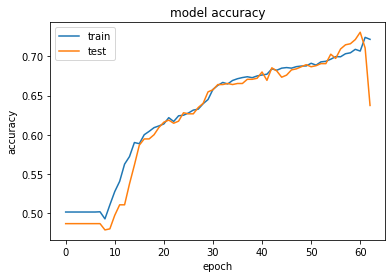

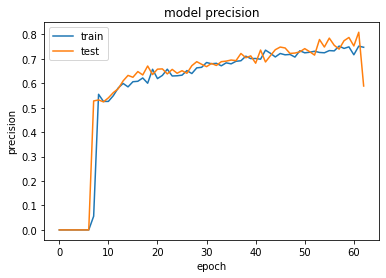

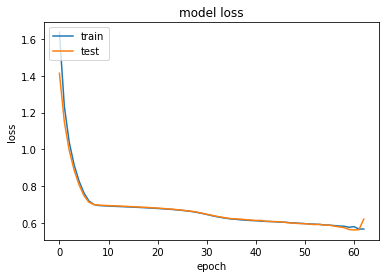

Epoch 1/100
106/106 [==============================] - 42s 400ms/step - loss: 0.6885 - accuracy: 0.5483 - precision: 0.5013 - recall: 0.9587 - f1_score: 0.6576 - val_loss: 0.6928 - val_accuracy: 0.4960 - val_precision: 0.6917 - val_recall: 0.0216 - val_f1_score: 0.0418
Epoch 2/100
106/106 [==============================] - 42s 396ms/step - loss: 0.6652 - accuracy: 0.6636 - precision: 0.7103 - recall: 0.5471 - f1_score: 0.6163 - val_loss: 0.6904 - val_accuracy: 0.5160 - val_precision: 0.9247 - val_recall: 0.0701 - val_f1_score: 0.1298
Epoch 3/100
106/106 [==============================] - 42s 397ms/step - loss: 0.6316 - accuracy: 0.6705 - precision: 0.7091 - recall: 0.5639 - f1_score: 0.6279 - val_loss: 0.6829 - val_accuracy: 0.5587 - val_precision: 0.9138 - val_recall: 0.1689 - val_f1_score: 0.2849
Epoch 4/100
106/106 [==============================] - 42s 395ms/step - loss: 0.6177 - accuracy: 0.6754 - precision: 0.7468 - recall: 0.5566 - f1_score: 0.6376 - val_loss: 0.6669 - val_accur

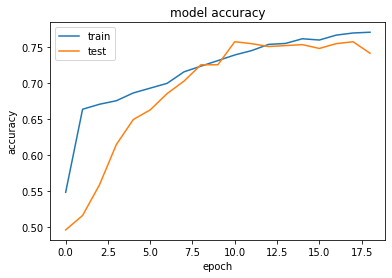

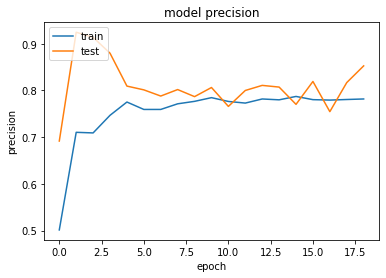

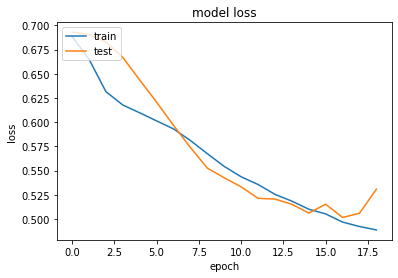

Epoch 1/100
106/106 [==============================] - 62s 581ms/step - loss: 0.6931 - accuracy: 0.5302 - precision: 0.4917 - recall: 0.5424 - f1_score: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5133 - val_precision: 0.5141 - val_recall: 1.0000 - val_f1_score: 0.6786
Epoch 2/100
106/106 [==============================] - 64s 605ms/step - loss: 0.6891 - accuracy: 0.6550 - precision: 0.7388 - recall: 0.4385 - f1_score: 0.5496 - val_loss: 0.6914 - val_accuracy: 0.5133 - val_precision: 0.5141 - val_recall: 1.0000 - val_f1_score: 0.6786
Epoch 3/100
106/106 [==============================] - 61s 572ms/step - loss: 0.6295 - accuracy: 0.6766 - precision: 0.7307 - recall: 0.5238 - f1_score: 0.6099 - val_loss: 0.6645 - val_accuracy: 0.6813 - val_precision: 0.6910 - val_recall: 0.6276 - val_f1_score: 0.6569
Epoch 4/100
106/106 [==============================] - 61s 571ms/step - loss: 0.5854 - accuracy: 0.7104 - precision: 0.7463 - recall: 0.6205 - f1_score: 0.6774 - val_loss: 0.6322 - val_accur

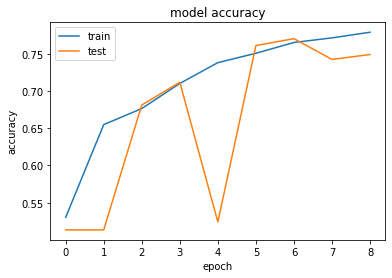

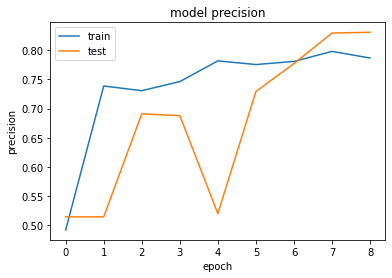

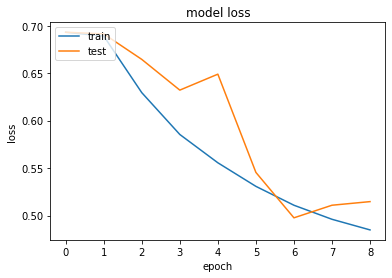

In [ ]:
if __name__ == '__main__':  

  # BiLSTM
  bilstm = createLSTM()
  train(bilstm, train_data)
  # test_model(bilstm, test_data)

  #CNN light
  cnn = createCNN()
  train(cnn, train_data)
  # test_model(cnn, test_data)

  #CNN ALexandre no weights
  model = create_model()
  train(model, train_data)
  # test_model(model, test_data)


In [ ]:
def test_print(model, data):
  # for i, ds in enumerate(data):
    x_test = np.array(test_data[3])
    y_test = np.array(test_data[2])

    preds = model.predict_on_batch(x_test)
    preds = [1 if preds[i][0] > 0.5 else 0 for i in range(preds.shape[0])]
    # print(preds)
    # print(test_data[2])
    tp_ = tp(preds, y_test)
    fp_ = fp(preds, y_test)
    fn_ = fn(preds, y_test)
    tn_ = tn(preds, y_test)
    a = accuracy(tp_, tn_, fp_, fn_)
    p = precision(tp_, fp_)
    r = recall(tp_, fn_)
    f1 = f1_score(p, r)

    p_n = precision_negative(tn_, fn_)
    r_n = recall_negative(tn_, fp_)
    f1_n = f1_score(p_n, r_n)

    print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
    print(f"tn: {tn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
    print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
    print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
    print(f"accuracy: {a} ")
    print('positives')
    print(f"precision: {p}, recall: {r}, f1: {f1}")
    print('negatives')
    print(f"precision: {p_n}, recall: {r_n}, f1: {f1_n}")

print("BiLSTM")
test_print(bilstm, test_data)
print("CNN")
test_print(cnn, test_data)
print("CNN Alexandre")
test_print(model, test_data)


BiLSTM
tp: 471, nb_pos: 500
tn: 165, nb_neg: 500
fp: 335, nb_pos: 500
fn: 29, nb_neg: 500
accuracy: 0.636 
positives
precision: 0.5843672456575683, recall: 0.942, f1: 0.7212863705972435
negatives
precision: 0.8505154639175257, recall: 0.33, f1: 0.4755043227665706
CNN
tp: 314, nb_pos: 500
tn: 436, nb_neg: 500
fp: 64, nb_pos: 500
fn: 186, nb_neg: 500
accuracy: 0.75 
positives
precision: 0.8306878306878307, recall: 0.628, f1: 0.7152619589977222
negatives
precision: 0.7009646302250804, recall: 0.872, f1: 0.7771836007130124
CNN Alexandre
tp: 335, nb_pos: 500
tn: 427, nb_neg: 500
fp: 73, nb_pos: 500
fn: 165, nb_neg: 500
accuracy: 0.762 
positives
precision: 0.821078431372549, recall: 0.67, f1: 0.737885462555066
negatives
precision: 0.7212837837837838, recall: 0.854, f1: 0.7820512820512819
